In [48]:
import requests
import json
import time
import math
import re
import calendar
import dateutil.parser as parser
from dateutil.relativedelta import relativedelta
from datetime import datetime, timezone
import yaml
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import os, sys, glob
import kaleido
from PIL import Image
from fpdf import FPDF
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [49]:
now = datetime.now()

In [50]:
def convert_date(utc_time): 
    parsed_date = parser.parse(utc_time)
    var_date=parsed_date.date()
    var_time=parsed_date.time()
    var_f_time=var_time.hour
    var_julian_date=parsed_date.timetuple().tm_yday
    var_weekday=parsed_date.weekday()
    var_weekday_name=calendar.day_name[parsed_date.weekday()]
    return var_date, var_time, var_f_time, var_julian_date, var_weekday, var_weekday_name

In [51]:
def eda(data):
    output=[]
    for col in data.columns:
        duplicatedvalue = data[col].duplicated().sum()
        duplicatedrows = data.duplicated().sum()
        missingvalue = np.sum(pd.isna(data[col]))
        uniquevalue = data[col].nunique()
        datatype = str(data[col].dtype)
        
        output.append([col, duplicatedvalue, duplicatedrows, missingvalue, uniquevalue, datatype])
        
    output = pd.DataFrame(output) 
    output.columns = ['Features', 'Duplicated Values', 'Duplicated Rows', 'Missing Values', 'Unique Values', 'Data Type']
    display(output)

In [52]:
def get_last_value(value):
    last = value
    return last

In [53]:
def perc_on_bar(plot, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = "{:.1f}%".format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size=12)
    plt.show()

In [54]:
def viz(data, indice):
    fig = go.Figure(data=[go.Candlestick(x=data['UTC_Time'],
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'])])

    fig.update_layout(xaxis_rangeslider_visible=False,
                      title="Neighbor: " + indice + " " + pair + " " + timeframe + " " + now.strftime("%Y-%m-%d %H:%M:%S"),
                      title_font_color="blue",
                      title_font_size = 20)
    
    fig.update_xaxes(rangebreaks=[dict(bounds=["sat", "mon"])])
    
    fig.write_image(path + "/" + indice + "_chart.png")
    
    fig.show()

In [55]:
def market_order(instrument, units, take_profit, stop_loss):
    login_request_body = {
        "order": {
            "type": "MARKET",
            "instrument": instrument,
            "units": units,
            "timeInForce": "IOC",
            "positionFill": "DEFAULT",
            "takeProfitOnFill": {
                "price": take_profit
            },
            "stopLossOnFill": {
                "price": stop_loss
            }
        }
    }
    response = requests.post(provider_api_url, data=json.dumps(login_request_body),
                             headers=request_headers,
                             verify=False)
    response
    response.status_code

### The Configs for Run:

In [9]:
with open ('config.yml') as ymlfile:
    cfg = yaml.safe_load(ymlfile)
    oanda_api_key = cfg['creds']['oanda_api']
    account_number = cfg['creds']['account_number'] 

# <font color='red'>Currency Pair</font>

In [56]:
Load_10K_Records=True


asia = ['EUR_NZD','EUR_AUD','GBP_NZD','GBP_AUD','AUD_USD','AUD_CAD','AUD_CHF','AUD_NZD','NZD_USD','NZD_CHF','NZD_CAD']

currency_pairs = ['EUR_USD','EUR_GBP','EUR_NZD','EUR_AUD','EUR_CHF','EUR_CAD',
                  'GBP_USD','GBP_CHF','GBP_NZD','GBP_AUD','GBP_CAD','AUD_USD',
                  'AUD_CAD','AUD_CHF','AUD_NZD','NZD_USD','NZD_CHF','NZD_CAD',
                  'USD_CAD','USD_CHF','CAD_CHF']

currency_pairs = ["EUR_USD"]


timeframe = "H4"
#D #H1 #H4 M30
# https://developer.oanda.com/rest-live-v20/instrument-df/#CandlestickGranularity
price_char = "M"
#M(midpoint candles) #B(bid candles) #A(ask candles) #BA
price_com = "mid"
#mid #bid #ask

# def of OANDA request variable
provider_api_url = 'https://api-fxpractice.oanda.com/v3/accounts/101-001-16477519-001/orders'
request_headers = {
    "Authorization": oanda_api_key,
    "Accept-Datetime-Format": "RFC3339",
    "Connection": "Keep-Alive",
    "Content-Type": "application/json;charset=UTF-8"
}


In [57]:
provider_authorization = 'Bearer {0}'.format(oanda_api_key)

headers = {
    'Content-Type': 'application/json',
    'Authorization': provider_authorization,
}

### Logging

In [58]:
now = datetime.now()
for pair in currency_pairs:
    Log_Folder = now.strftime("%d-%m-%Y_%I-%M_%p")
    path = os.path.join(Log_Folder+"_"+pair)
    os.mkdir(path)

# Get Candlesticks Data

### Pricing & Spread Cost

In [59]:
for pair in currency_pairs:
    pricing_params = (
        ('instruments', pair),
    )
    response = requests.get('https://api-fxpractice.oanda.com/v3/accounts/{}/pricing'.format(account_number),
                            headers=headers,
                            params=pricing_params).json()

In [60]:
time = response['time']
ask = response['prices'][0]['closeoutAsk']
bid = response['prices'][0]['closeoutBid']
print ('Date:', time, 'Ask:', ask, 'Bid:', bid)

Date: 2021-11-02T02:32:14.648985103Z Ask: 1.15978 Bid: 1.15973


### Open Positions

In [61]:
response = requests.get('https://api-fxpractice.oanda.com/v3/accounts/{}/openPositions'.format(account_number),
                            headers=headers,
                            params=pricing_params).json()
response['positions']

[{'instrument': 'USD_CAD',
  'long': {'units': '0',
   'pl': '5946.5299',
   'resettablePL': '5946.5299',
   'financing': '-63.7508',
   'dividendAdjustment': '0.0000',
   'guaranteedExecutionFees': '0.0000',
   'unrealizedPL': '0.0000'},
  'short': {'units': '-1500000',
   'averagePrice': '1.23583',
   'pl': '6714.0938',
   'resettablePL': '6714.0938',
   'financing': '-98.7782',
   'dividendAdjustment': '0.0000',
   'guaranteedExecutionFees': '0.0000',
   'tradeIDs': ['7380'],
   'unrealizedPL': '-2496.5969'},
  'pl': '12660.6237',
  'resettablePL': '12660.6237',
  'financing': '-162.5290',
  'commission': '3355.0400',
  'dividendAdjustment': '0.0000',
  'guaranteedExecutionFees': '0.0000',
  'unrealizedPL': '-2496.5969',
  'marginUsed': '30000.0000'}]

###  Candlestick Data

In [62]:
params_count = (
    ('price', price_char),
    ('count', '5000'),
    ('granularity', timeframe),
)


In [63]:
for pair in currency_pairs:
    first_response = requests.get('https://api-fxpractice.oanda.com/v3/instruments/{}/candles'.format(pair), 
                            headers=headers,
                            params=params_count).json()

In [64]:
if Load_10K_Records:
    datetime_object = parser.parse(first_response['candles'][0]['time'])
    date= datetime_object - relativedelta(years=3)  
    from_date = date.replace(tzinfo=timezone.utc).timestamp()
    params_date = (
        ('count', '5000'),
        ('price', price_char),
        ('from', from_date),
        ('granularity', timeframe),)

    second_response = requests.get('https://api-fxpractice.oanda.com/v3/instruments/{}/candles'.format(pair),
                                   headers=headers,
                                   params=params_date).json()
            
    first_response= first_response['candles']  
    second_response= second_response['candles']
    second_response.extend(first_response)
    response=second_response
else:
    response=first_response['candles']

In [65]:
filename = "{}_{}.csv".format(pair, timeframe)
output = []
all_candlesticks = response

for i in range (len(all_candlesticks)):
    result= (convert_date(response[i]['time']))
    output.append([(result[0]),(result[1]),(result[2]),(result[3]),(result[4]),(result[5]),
                    response[i]['time'],
                    response[i]['volume'], 
                    response[i][price_com]['o'],
                    response[i][price_com]['h'],
                    response[i][price_com]['l'],
                    response[i][price_com]['c']])
    
output = pd.DataFrame(output)
output.columns = ['Date','Time','f_time','julian_date','Weekday','Weekday_Name','UTC_Time', 'Volume', 'Open', 'High', 'Low', 'Close']
data = output.to_csv(filename, header = True, index = False)
data = pd.read_csv(filename)

In [66]:
data = data.drop_duplicates()
data = data.to_csv(filename, header = True, index = False)
data = pd.read_csv(filename)

In [67]:
data.shape

(9660, 12)

In [68]:
data.head(2)

,Date,Time,f_time,julian_date,Weekday,Weekday_Name,UTC_Time,Volume,Open,High,Low,Close
0,2015-08-16,21:00:00,21,228,6,Sunday,2015-08-16T21:00:00.000000000Z,1930,1.11197,1.11218,1.10916,1.10953
1,2015-08-17,01:00:00,1,229,0,Monday,2015-08-17T01:00:00.000000000Z,1711,1.10955,1.11016,1.10822,1.10900


In [69]:
data.tail(2)

,Date,Time,f_time,julian_date,Weekday,Weekday_Name,UTC_Time,Volume,Open,High,Low,Close
9658,2021-11-01,21:00:00,21,305,0,Monday,2021-11-01T21:00:00.000000000Z,1962,1.16042,1.16064,1.15954,1.15970
9659,2021-11-02,01:00:00,1,306,1,Tuesday,2021-11-02T01:00:00.000000000Z,1256,1.15972,1.15984,1.15951,1.15976


## Calculate Average True Range (ATR)

In [70]:
high_low = data['High'] - data['Low']
high_cp = np.abs(data['High'] - data['Close'].shift())
low_cp = np.abs(data['Low'] - data['Close'].shift())
df = pd.concat([high_low, high_cp, low_cp], axis=1)
true_range = np.max(df, axis=1)
data['ATR_14'] = true_range.rolling(14).mean()

In [71]:
data = data.drop_duplicates()
data = data.to_csv(filename, header = True, index = False)
data = pd.read_csv(filename)

In [72]:
data.tail(2)

,Date,Time,f_time,julian_date,Weekday,Weekday_Name,UTC_Time,Volume,Open,High,Low,Close,ATR_14
9658,2021-11-01,21:00:00,21,305,0,Monday,2021-11-01T21:00:00.000000000Z,1962,1.16042,1.16064,1.15954,1.15970,0.002685
9659,2021-11-02,01:00:00,1,306,1,Tuesday,2021-11-02T01:00:00.000000000Z,1256,1.15972,1.15984,1.15951,1.15976,0.002579


# Feature Engineering

### CandleStick Data

In [73]:
data['O-H'] = data['Open'] - data['High']
data['O-L'] = data['Open'] - data['Low']
data['O-C'] = data['Open'] - data['Close']
data['H-L'] = data['High'] - data['Low']
data['H-C'] = data['High'] - data['Close']
data['L-C'] = data['Low'] - data['Close']

data['Direction'] = data['O-C'].apply(lambda x: 1 if x<0 else 0)

data['col_1'] = data['Open'] - data['Close']

for value in data['col_1']:   
    if value > 0:
        data['col_2'] = data['High'] - data['Open']
        data['col_3'] = data['Close'] - data['Low']
    else:
        data['col_2'] = data['High'] - data['Close']
        data['col_3'] = data['Open'] - data['Low']

#Two Previous Candlesticks 
data['col_4'] = data['col_1'].shift(1)
data['col_5'] = data['col_1'].shift(2)

#Moving Avarage
data['SMA_10'] = data['Close'].rolling(window=5).mean()
data['SMA_20'] = data['Close'].rolling(window=10).mean()

#Feature Engineering Moving Avarage 
data['F_SMA_10'] = data['Close'] - data['SMA_10']
data['F_SMA_20'] = data['Close'] - data['SMA_20']

In [74]:
data = data.dropna()

In [75]:
data = data.to_csv(filename, header = True, index = False)

In [76]:
data = pd.read_csv(filename)

In [77]:
data.tail()

,Date,Time,f_time,julian_date,Weekday,Weekday_Name,UTC_Time,Volume,Open,High,...,Direction,col_1,col_2,col_3,col_4,col_5,SMA_10,SMA_20,F_SMA_10,F_SMA_20
9642,2021-11-01,09:00:00,9,305,0,Monday,2021-11-01T09:00:00.000000000Z,18317,1.15722,1.15799,...,1,-0.00054,0.00023,0.00102,-0.00204,0.00035,1.156366,1.159821,0.001394,-0.002061
9643,2021-11-01,13:00:00,13,305,0,Monday,2021-11-01T13:00:00.000000000Z,21754,1.15775,1.15941,...,1,-0.00145,0.00021,0.00119,-0.00054,-0.00204,1.156968,1.158897,0.002232,0.000303
9644,2021-11-01,17:00:00,17,305,0,Monday,2021-11-01T17:00:00.000000000Z,7929,1.15921,1.16090,...,1,-0.00141,0.00028,0.00036,-0.00145,-0.00054,1.157992,1.158315,0.002628,0.002305
9645,2021-11-01,21:00:00,21,305,0,Monday,2021-11-01T21:00:00.000000000Z,1962,1.16042,1.16064,...,0,0.00072,0.00094,0.00088,-0.00141,-0.00145,1.158900,1.157777,0.000800,0.001923
9646,2021-11-02,01:00:00,1,306,1,Tuesday,2021-11-02T01:00:00.000000000Z,1256,1.15972,1.15984,...,1,-0.00004,0.00008,0.00021,0.00072,-0.00141,1.159408,1.157497,0.000352,0.002263


# <font color='red'>CANDLE INDEX NUMBER</font>

In [78]:
candle_no = len(data) - 2
candle_no

9645

# Calculating Stop Loss

In [79]:
STOP_LOSS = data.iloc[candle_no]['ATR_14']
STOP_LOSS

0.002685

In [80]:
CLOSED_PRICE = data.iloc[candle_no]['Close']
CLOSED_PRICE

1.1597

In [81]:
BUY_SL = CLOSED_PRICE - STOP_LOSS
BUY_SL = BUY_SL.round(5)

In [82]:
SELL_SL = CLOSED_PRICE + STOP_LOSS
SELL_SL = SELL_SL.round(5)

# Modeling

In [83]:
data = pd.read_csv(filename)

### Feature Selection and Reduction

In [84]:
data = data.drop(columns=['Volume','Weekday','Date','Time',
                          'Weekday_Name','UTC_Time','Direction',
                          'Open', 'High', 'Low', 'Close',
                          'O-H','O-L','O-C','H-L','H-C','L-C',
                          'SMA_10','SMA_20',
                          'f_time','julian_date','ATR_14',
#                          'col_1','col_2','col_3',
                          'col_4','col_5',
#                          'F_SMA_10','F_SMA_20'
                         ])

# Comment out the features that you want to fit into your model.

### Feature Being Fit to the Model

In [85]:
data.head()

,col_1,col_2,col_3,F_SMA_10,F_SMA_20
0,-0.00109,0.00037,0.00019,0.001388,-0.000468
1,-0.00046,0.00196,0.00009,0.001438,0.000273
2,0.00168,0.00396,0.00358,-0.000378,-0.001030
3,-0.00210,0.00128,0.00144,0.001090,0.001248
4,-0.00618,0.00144,0.00224,0.005650,0.006805


### Scaling using Standard Scaler

In [86]:
def find_k_similar_candles(candle_id, dataset, k=4):
    indices=[]
    distances = []
    output = []
    model_knn = NearestNeighbors(metric = 'euclidean', algorithm = 'auto') 
    model_knn.fit(dataset)
    
    #metric = 'euclidean' or 'cosine' or 'manhattan' or 'mahalanobis'
    
    distances, indices = model_knn.kneighbors(dataset.iloc[candle_id,:].values.reshape(1,-1),
                                              n_neighbors = k)

    for i in range(0,len(distances.flatten())):
        if i==0:
            display (pd.DataFrame(data.iloc[candle_id]).transpose())
            #print("Recommendation for {0}:\n".format(eurusd_data.index[candle_id]))
        else:
            #print("{0}: {1}, with distance of {2}".format(i,
            #                                               dataset.index[indices.flatten()[i]],
            #                                               distances.flatten()[i]))
            
            output.append ([dataset.index[indices.flatten()[i]],
                            distances.flatten()[i],
#                           dataset.iloc[indices.flatten()[i]]['O-H'],dataset.iloc[indices.flatten()[i]]['O-L'],dataset.iloc[indices.flatten()[i]]['O-C'],dataset.iloc[indices.flatten()[i]]['H-L'],dataset.iloc[indices.flatten()[i]]['H-C'],dataset.iloc[indices.flatten()[i]]['L-C'],
                           dataset.iloc[indices.flatten()[i]]['col_1'],dataset.iloc[indices.flatten()[i]]['col_2'],dataset.iloc[indices.flatten()[i]]['col_3'],
#                           dataset.iloc[indices.flatten()[i]]['col_4'],dataset.iloc[indices.flatten()[i]]['col_5'],
                           dataset.iloc[indices.flatten()[i]]['F_SMA_10'],dataset.iloc[indices.flatten()[i]]['F_SMA_20'],
                           ])
    
    output = pd.DataFrame(output)
    output.columns = ['Indice','Distance',
#                      'O-H','O-L','O-C','H-L','H-C','L-C',
                      'col_1','col_2','col_3',
#                      'col_4','col_5',
                      'F_SMA_10','F_SMA_20'
                     ]
    display (output)
    
    return indices, distances

### Top 5 Similar Candlesticks

In [87]:
indices, distances = find_k_similar_candles (candle_no,data)

,col_1,col_2,col_3,F_SMA_10,F_SMA_20
9645,0.00072,0.00094,0.00088,0.0008,0.001923


,Indice,Distance,col_1,col_2,col_3,F_SMA_10,F_SMA_20
0,6608,0.000292,0.00081,0.00099,0.00100,0.000636,0.001741
1,2862,0.000341,0.00048,0.00080,0.00076,0.000932,0.001839
2,1273,0.000354,0.00076,0.00105,0.00096,0.000578,0.001687


In [88]:
indices = indices[0:1][0]

In [89]:
indices

array([9645, 6608, 2862, 1273])

### Currnet Market/Candlestick

In [90]:
closed_candle = "currnet_market_data.csv"
data = pd.read_csv(filename)
data = data.iloc[candle_no-30:candle_no+1]
data.to_csv(path + "/" + closed_candle, header = True, index = False)
viz(data, "current_market")

### Recommendations

In [91]:
print(datetime.now())

2021-11-01 21:32:27.864930


Neighbor: 6608 | 10K Records: True


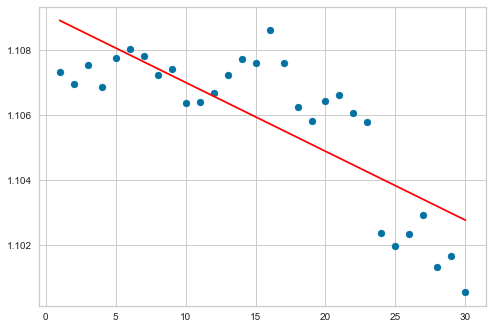

63.0 % Fit
Action: SELL
STOP LOSS: 1.16238
Neighbor: 2862 | 10K Records: True


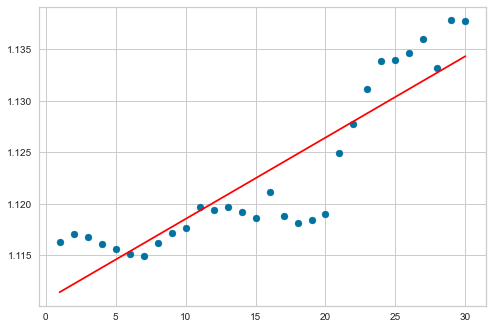

79.0 % Fit
Action: BUY
STOP LOSS: 1.15701
Neighbor: 1273 | 10K Records: True


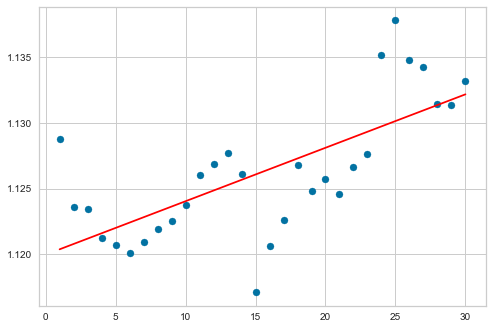

48.0 % Fit
Action: BUY
STOP LOSS: 1.15701


In [92]:
for indice in indices[1:10]:
    recommendation_log = "{}_data.csv".format(indice)
    data = pd.read_csv(filename) 
    data = data.iloc[indice:indice+30]
    data.to_csv(path + "/" + recommendation_log, header = True, index = False)
    
    print ('Neighbor:', indice, '|', '10K Records:', Load_10K_Records)
    viz(data, indice.astype(str))
    
    data['candleno'] = range (1, len(data) + 1)
    X = data['candleno'].values.reshape(-1, 1)
    Y = data['Close'].values.reshape(-1, 1)
    linear_regressor = LinearRegression()
    linear_regressor.fit(X, Y)
    y_pred = linear_regressor.predict(X)
    plt.scatter(X, Y)
    plt.plot(X, y_pred, color='red')
    plt.show()
    
    print(r2_score(Y, y_pred).round(2)*100, '% Fit')
    coeficient = (linear_regressor.coef_)
    
    if coeficient > 0:
        print('Action: BUY')
        print('STOP LOSS:', BUY_SL)
    else:
        print('Action: SELL')
        print('STOP LOSS:', SELL_SL)



### Save the Recommendations

In [93]:
currentpath = os.path.join(sys.path[0])
pngfiles = []
pngfiles = glob.glob(currentpath+"/"+path+"/*.png")
pdf = FPDF()

for pngfile in pngfiles:
    pdf.add_page()
    pdf.image(pngfile, w=200, h=130)
    
pdf.output(path+"/recommendations.pdf", "F")

''